In [2]:
from joblib import load
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import ibc_public
from nilearn.input_data import NiftiMasker
from nilearn.stats.second_level_model import SecondLevelModel
from nilearn.reporting import make_glm_report
from nilearn.image import new_img_like
import glob
import pandas as pd

%matplotlib inline

In [7]:
sr = load('/home/sshankar/raiders/hugo_exp/multiviewICA/shared_response')

In [10]:
print(len(sr), sr[0].shape)

11 (20, 3924)


In [30]:
mean_sr = np.zeros((20, 3924))
tmp_sr = np.zeros((11, 3924))

for c in range(20):
    for s in range(11):
        tmp_sr[s] = sr[s][c]
    mean_sr[c] = np.mean(tmp_sr, axis=0)

In [22]:
tmp_sr.shape

(11, 3924)

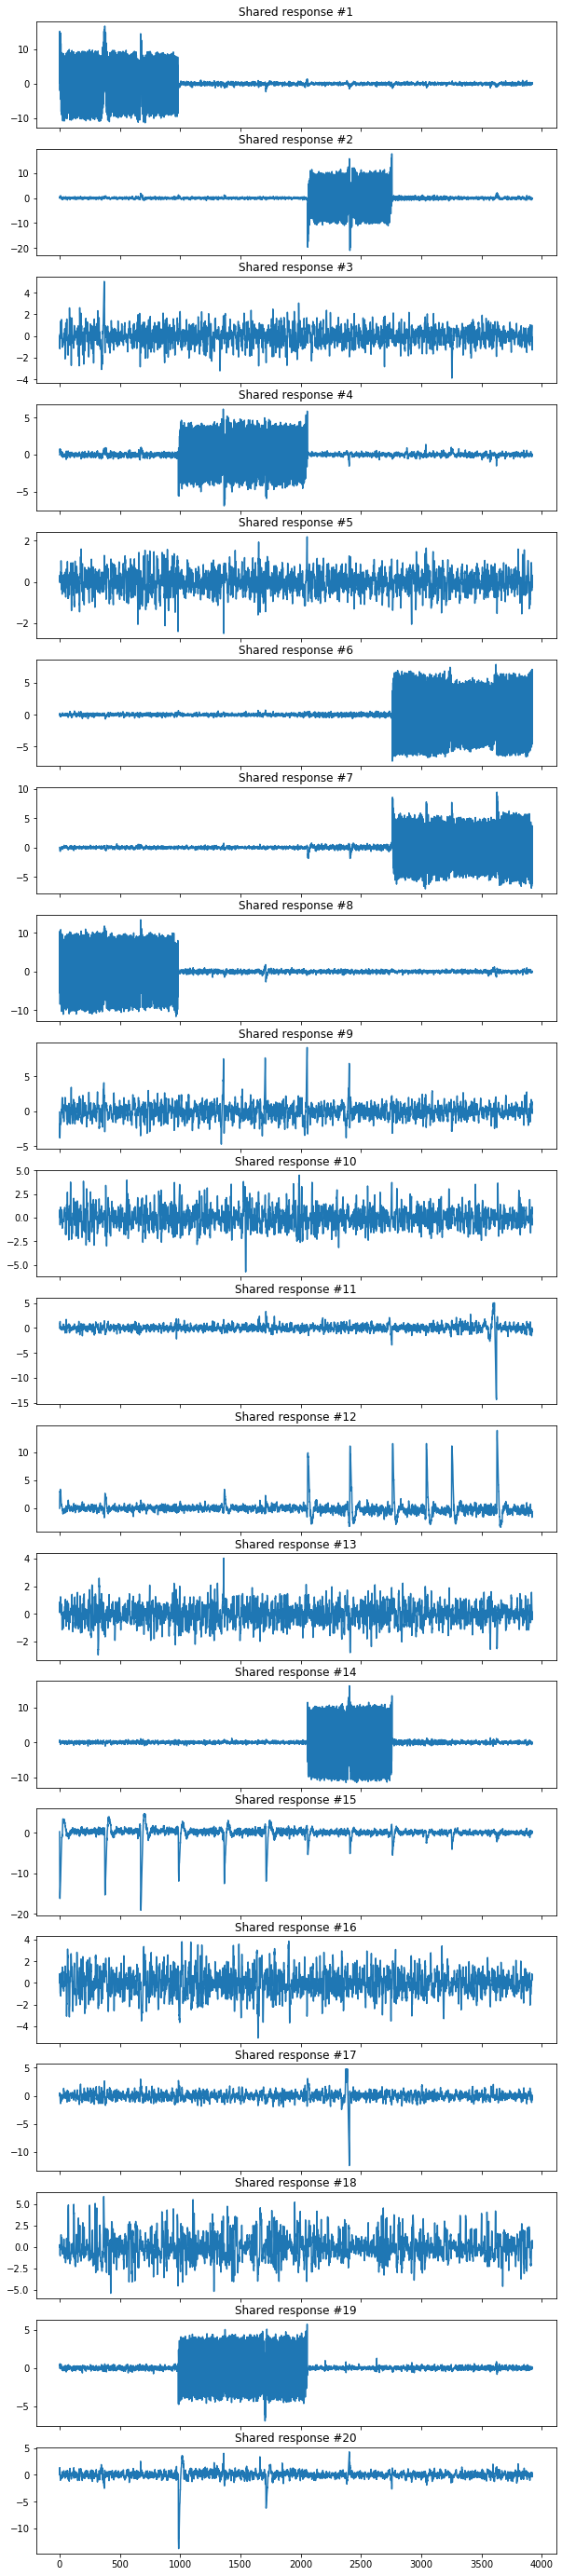

In [35]:
# These are what the shared responses look like
fig, axs = plt.subplots(20, sharex=True, 
                        figsize=(10,50))
for i in range(len(mean_sr)):
    axs[i].plot(mean_sr[i,:])
    axs[i].set_title('Shared response #' + str(i+1))
    

In [36]:
fig.savefig(os.path.join('/home/sshankar/raiders/hugo_exp/multiviewICA/', 'shared_resp.pdf'), format='pdf', transparent=False)

In [2]:
bl = load('/home/sshankar/raiders/hugo_exp/multiviewICA/basis')

In [4]:
print(len(bl), bl[0].shape)

11 (20, 212445)


In [5]:
# mask = nib.load('../ibc_github/public_analysis_code/ibc_data/gm_mask_3mm.nii.gz')
# mask = nib.load('../mask.nii.gz')
mask_gm = nib.load('../raiders/hugo_exp/multiviewICA/hcp_mask.nii.gz')

In [4]:
img_masker = NiftiMasker(mask_img=mask_gm).fit()

In [10]:
maps = []
n_comp = bl[0].shape[0]
for s in range(len(bl)):
    sub_path = os.path.join('../raiders/hugo_exp/multiviewICA/', 'sub-%02d' %(s+1))
    bls = bl[s]
    if not os.path.exists(sub_path):
        os.mkdir(sub_path)
    for c in range(n_comp):
        img = img_masker.inverse_transform(bls[c])
        nib.save(img, 
                 os.path.join(sub_path, 'basis_list-' + str(c).zfill(2) + '.nii.gz'))

In [3]:
# Do a group level analysis using these basis lists
nsub = 11
n_comp = 20
movie_dir = '../raiders/hugo_exp/multiviewICA/'

second_level_input = np.empty((nsub, n_comp), dtype='object')
subs = sorted(glob.glob(movie_dir + 'sub*'))

for s, sub in enumerate(subs):
    for c in range(n_comp):
        second_level_input[s][c] = os.path.join(
            sub, 'basis_list-' + str(c).zfill(2) + '.nii.gz')
        
design_matrix = pd.DataFrame([1] * len(second_level_input), columns=['intercept'])
second_level_model = SecondLevelModel()

In [6]:
# Compute the contrast/main effect
for i in range(20):
    z_map = second_level_model.fit(list(second_level_input[:,i]), 
                                    design_matrix=design_matrix).compute_contrast(output_type='z_score')
    nib.save(new_img_like(mask_gm, z_map.get_fdata()), 
             os.path.join(movie_dir, 'group', 'component-' + str(i).zfill(2) + '.nii.gz'))
    report = make_glm_report(second_level_model, 'intercept')
    report.save_as_html(os.path.join(movie_dir, 'group', 'component-' + 
                                    str(i+1).zfill(2) + '.html'))

/home/sshankar/nilearn/nilearn/reporting/_plot_matrices.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/home/sshankar/nilearn/nilearn/reporting/glm_reporter.py:307: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plot.figure.savefig(buffer, format='svg')
/home/sshankar/nilearn/nilearn/reporting/_get_clusters_table.py:137: UserWarning: Attention: No clusters with stat higher than 3.290527
  stat_threshold)
